In [126]:
import math
import random
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import imblearn

In [127]:
print(tf.__version__)

2.10.0


In [128]:
table = pd.read_table('./1663769555_8559356_train.txt', names=['binding','sequence'])

In [129]:
from sklearn.feature_extraction.text import CountVectorizer
def return_binary_vectorized_form(data_frame, feat = None):
    if feat is None:
        count_vectorizer = CountVectorizer(binary=True)
    else:
        count_vectorizer = CountVectorizer(binary=True, vocabulary=feat)
    fitted_and_transformed = count_vectorizer.fit_transform(data_frame).toarray()
    return count_vectorizer,  fitted_and_transformed

In [130]:
from sklearn.feature_selection import SelectKBest, chi2
def select_k_best_features(feature_set, target_values, fraction, feature_list):
    select_bestselect_best = SelectKBest(score_func=chi2, k = int(len(feature_list)*fraction))
    select_bestselect_best.fit(feature_set,target_values)
    mask = select_bestselect_best.get_support()
    k_best_featurs = feature_list[mask]
    return k_best_featurs

In [131]:
from sklearn.model_selection import train_test_split
active_df = table.loc[table.binding == 1]
not_active_df = table.loc[table.binding == 0]
# Mainly spliting the data here for testing, that is the reason train size is set to .20
active_train, active_test, active_binding_train, active_binding_test = train_test_split(active_df.sequence, active_df.binding, shuffle=True, train_size= .75)
not_active_train, not_active_test, not_active_binding_train, not_active_binding_test = train_test_split(not_active_df.sequence, not_active_df.binding, shuffle=True, train_size=.90)

In [132]:
def createDf(data):
    pd_df = pd.DataFrame(data)
    return pd_df
def addColumn(copy_to, copy_from ,cname):
    copy_to[cname] = copy_from[cname]
    return copy_to

In [133]:
active_test_df = pd.DataFrame(active_test)
active_binding_test_df = pd.DataFrame(active_binding_test)
active_test_df['binding'] = active_binding_test_df['binding']
not_active_test_df = pd.DataFrame(not_active_test)
not_active_binding_test_df = pd.DataFrame(not_active_binding_test)
not_active_test_df['binding'] = not_active_binding_test_df['binding']
active_train_df = createDf(active_train)
active_binding_train_df = createDf(active_binding_train)
active_train_df = addColumn(active_train_df, active_binding_train_df, 'binding')
not_active_train_df = createDf(not_active_train)
not_active_binding_train_df = createDf(not_active_binding_train)
not_active_train_df = addColumn(not_active_train_df, not_active_binding_train_df, 'binding')
train_df = pd.concat([active_train_df, not_active_train_df]).reset_index()
train_df = train_df.drop('index', axis=1)
print(train_df.binding.value_counts())
test_df = pd.concat([active_test_df, not_active_test_df]).reset_index()
test_df = test_df.drop('index', axis=1)
print(test_df.binding.value_counts())
from imblearn.over_sampling import RandomOverSampler, BorderlineSMOTE, SMOTE




0    649
1     58
Name: binding, dtype: int64
0    73
1    20
Name: binding, dtype: int64


In [134]:
sampler = RandomOverSampler(sampling_strategy=1)
x_sampled, y_sampled = sampler.fit_resample(np.array(train_df.sequence).reshape(-1, 1), train_df.binding)

final_train_set = pd.DataFrame(x_sampled, columns  =["sequence"])
final_train_set['binding'] = y_sampled
print(final_train_set.binding.value_counts())

final_test_set = pd.DataFrame(test_df.sequence, columns  =["sequence"])
final_test_set['binding'] = test_df.binding
print(final_test_set.binding.value_counts())

1    649
0    649
Name: binding, dtype: int64
0    73
1    20
Name: binding, dtype: int64


In [135]:
train_result = np.array(final_train_set.binding)
test_result = np.array(final_test_set.binding)

In [136]:
vectorizer_best, training_split = return_binary_vectorized_form(final_train_set.sequence)
features = select_k_best_features(training_split,final_train_set.binding,.20,vectorizer_best.get_feature_names_out())
features

array(['10000', '10008', '10012', ..., '99976', '9998', '99989'],
      dtype=object)

In [137]:
vectorizer_best, training_split = return_binary_vectorized_form(final_train_set.sequence,features)
test_split = vectorizer_best.transform(final_test_set.sequence).toarray()

In [138]:
# smote = (random_state=42, sampling_strategy=.65)
# x, y = smote.fit_resample(training_split, train_result)
# training_split = x
# train_result = y
# print(training_split.shape)
# print(test_split.shape)

In [139]:
initial_weight = np.ones(training_split.shape[0])*(1/training_split.shape[0])

In [140]:
def updateWeight(missmatch, weight, alpha):
    mi = 0
    missmatch_size = len(missmatch)
    wi = 0

    new_weight = []
    norm_constant = 0
    while wi < len(weight):
        if mi < missmatch_size and missmatch[mi] == wi:
            k = weight[wi] * math.exp(alpha)
            mi+=1
        else:
            k = weight[wi] * math.exp(-1*alpha)
        new_weight.append( k )
        norm_constant += k
        wi += 1

    new_weight /= norm_constant
    sum =0
    for i in new_weight:
        sum+=i
    print(sum)
    # plt.plot(new_weight)
    # plt.show()
    return new_weight

In [141]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
def findMissClassificatonIndex(predicted, test_res, weight):
    error_rate = 0
    missmatch_indexes = []
    incorrect= []
    tn, fp, fn, tp = confusion_matrix(test_res, predicted).ravel()
    precision = tp / (tp+ fp)
    recall = tp / (tp+ fn)
    score = (2 * precision * recall) / (precision + recall)
    print(score)
    print(accuracy_score(test_res, predicted))
    for i, (pred, real) in enumerate(zip(predicted, test_res)):
        if pred != real:
            incorrect.append((i, pred, real))
            missmatch_indexes.append(i)
            error_rate += weight[i]
    error_rate /= len(predicted)
    # print(incorrect)
    return error_rate, missmatch_indexes

In [142]:
def resample(train_data, train_res, weights):
    size = len(train_data)
    indexes = np.random.choice(int(size), int( .10 * size), replace=True, p=weights)
    new_train_data = []
    new_train_res = []
    for index in indexes:
         new_train_data.append(train_data[index])
         new_train_res.append(train_res[index])
    return np.array(new_train_data), np.array(new_train_res)

In [190]:
class EarlyStoppingMonitor(tf.keras.callbacks.Callback):
    def __init__(self):
        super(EarlyStoppingMonitor, self).__init__()
        self.f1_train = None
        self.f1_test = None
        self.prevous = None
        self.count =0

    def on_epoch_end(self, epoch, logs=None):
        current_train_precision = logs.get('precision')
        current_train_recall= logs.get('recall')

        if current_train_precision==0 or current_train_recall==0:
            print("**** Waring: precision recall zero avoid exception ****")
            return
        self.f1_train = (2*current_train_precision*current_train_recall) / (current_train_precision+current_train_recall)
        if self.prevous == None:
            self.prevous = self.f1_train
        if self.prevous == self.f1_train:
            self.count += 1
        else:
            self.prevous = self.f1_train
            self.count = 0
        if self.count == 5:
            self.model.stop_training = True
            print('\n\n******* No improvements *******')
        if current_train_recall > .35 and current_train_precision > .75:
            # self.count += 1
            # if self.count >4:
            self.model.stop_training = True
            print('\n\n******* Stoping on Defined Thresold *******')
            print('F1 TRAINING: ', self.f1_train)
            print('Recall TRAINING: ', current_train_recall)

    def on_train_end(self, logs=None):
        if self.model.stop_training:
            print("\n\n\n****** Early Stopping *******")

In [191]:
def createBaseModel():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(training_split.shape[-1],)),
        tf.keras.layers.Dense(2, activation='relu',kernel_regularizer=tf.keras.regularizers.L1(.015)),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
    ]

    model.compile(loss=tf.keras.losses.BinaryFocalCrossentropy(), metrics=METRICS, optimizer='adam')

    return model

In [192]:
ensemble_size = 30
ensemble = []
alphas = []
sample_percentage = []
def boosting(weights):

    for i in range(ensemble_size):
        print(" =========== iteration ===========>:", i )
        train_data, train_res = resample(training_split, train_result, weights)
        model = createBaseModel()
        num_epochs = 60
        score = ((sum(train_res)/len(train_res)))*100
        sample_percentage.append( score )
        print( "bfore traning: ",score )
        history = model.fit(train_data, train_res,
                    epochs= num_epochs,
                    batch_size=70,
                    callbacks=[EarlyStoppingMonitor()])
        predicted_result = model.predict(training_split)
        predicted_result = [1 if i>=.5 else 0 for i in predicted_result ]
        error_rate, error_indexes = findMissClassificatonIndex(predicted_result, train_result, weights)
        print("error_rate:", error_rate)

        if error_rate > .5:
            weights = np.ones(training_split.shape[0]) * (1/training_split.shape[0])
            print("re-balancing and training because error:", error_rate)
            continue

        amount_of_say = .012 * ( math.log( (1-error_rate) / error_rate ) )
        alphas.append(amount_of_say)
        ensemble.append(model)
        weights = updateWeight(error_indexes, weights, amount_of_say)


In [193]:
# plt.plot(initial_weight)
boosting(initial_weight)

 =========== iteration ===========>: 0
bfore traning:  49.6124031007752
Epoch 1/60


2022-11-15 08:38:31.582218: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 2s 716ms/step - loss: 4.6983 - tp: 27.0000 - fp: 28.0000 - tn: 37.0000 - fn: 37.0000 - precision: 0.4909 - recall: 0.4219
Epoch 2/60
2/2 [==============================] - 0s 219ms/step - loss: 3.8660 - tp: 60.0000 - fp: 40.0000 - tn: 25.0000 - fn: 4.0000 - precision: 0.6000 - recall: 0.9375
Epoch 3/60
2/2 [==============================] - 0s 102ms/step - loss: 3.1345 - tp: 63.0000 - fp: 39.0000 - tn: 26.0000 - fn: 1.0000 - precision: 0.6176 - recall: 0.9844
Epoch 4/60
2/2 [==============================] - 0s 122ms/step - loss: 2.4944 - tp: 64.0000 - fp: 34.0000 - tn: 31.0000 - fn: 0.0000e+00 - precision: 0.6531 - recall: 1.0000
Epoch 5/60
2/2 [==============================] - 0s 111ms/step - loss: 1.9536 - tp: 64.0000 - fp: 28.0000 - tn: 37.0000 - fn: 0.0000e+00 - precision: 0.6957 - recall: 1.0000
Epoch 6/60
2/2 [==============================] - 0s 114ms/step - loss: 1.5099 - tp: 64.0000 - fp: 24.0000 - tn: 41.0000 - fn: 0.0000e+00 - precisi

2022-11-15 08:38:35.073338: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 5ms/step
0.9109639440765269
0.9067796610169492
error_rate: 7.181844297615635e-05
1.000000000000004
 =========== iteration ===========>: 1
bfore traning:  51.162790697674424
Epoch 1/60


2022-11-15 08:38:35.626380: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 2s 603ms/step - loss: 4.6480 - tp: 7.0000 - fp: 9.0000 - tn: 54.0000 - fn: 59.0000 - precision: 0.4375 - recall: 0.1061
Epoch 2/60
2/2 [==============================] - 0s 191ms/step - loss: 3.7744 - tp: 23.0000 - fp: 21.0000 - tn: 42.0000 - fn: 43.0000 - precision: 0.5227 - recall: 0.3485
Epoch 3/60
2/2 [==============================] - 0s 151ms/step - loss: 3.0175 - tp: 42.0000 - fp: 20.0000 - tn: 43.0000 - fn: 24.0000 - precision: 0.6774 - recall: 0.6364
Epoch 4/60
2/2 [==============================] - 0s 135ms/step - loss: 2.3708 - tp: 49.0000 - fp: 19.0000 - tn: 44.0000 - fn: 17.0000 - precision: 0.7206 - recall: 0.7424
Epoch 5/60
2/2 [==============================] - ETA: 0s - loss: 1.8322 - tp: 51.0000 - fp: 15.0000 - tn: 48.0000 - fn: 15.0000 - precision: 0.7727 - recall: 0.7727

******* Stoping on Defined Thresold *******
F1 TRAINING:  0.7727273106575012
Recall TRAINING:  0.7727273106575012
2/2 [==============================] - 0s 66

2022-11-15 08:38:38.551945: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 4ms/step
0.724191063174114
0.724191063174114
error_rate: 0.0002151168560613175
0.9999999999999758
 =========== iteration ===========>: 2
bfore traning:  46.51162790697674
Epoch 1/60


2022-11-15 08:38:39.073672: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 2s 787ms/step - loss: 4.6299 - tp: 54.0000 - fp: 65.0000 - tn: 4.0000 - fn: 6.0000 - precision: 0.4538 - recall: 0.9000
Epoch 2/60
2/2 [==============================] - 0s 185ms/step - loss: 3.7571 - tp: 50.0000 - fp: 67.0000 - tn: 2.0000 - fn: 10.0000 - precision: 0.4274 - recall: 0.8333
Epoch 3/60
2/2 [==============================] - 0s 81ms/step - loss: 2.9987 - tp: 47.0000 - fp: 56.0000 - tn: 13.0000 - fn: 13.0000 - precision: 0.4563 - recall: 0.7833
Epoch 4/60
2/2 [==============================] - 0s 184ms/step - loss: 2.3499 - tp: 46.0000 - fp: 52.0000 - tn: 17.0000 - fn: 14.0000 - precision: 0.4694 - recall: 0.7667
Epoch 5/60
2/2 [==============================] - 0s 110ms/step - loss: 1.8125 - tp: 45.0000 - fp: 42.0000 - tn: 27.0000 - fn: 15.0000 - precision: 0.5172 - recall: 0.7500
Epoch 6/60
2/2 [==============================] - 0s 68ms/step - loss: 1.3858 - tp: 49.0000 - fp: 31.0000 - tn: 38.0000 - fn: 11.0000 - precision: 0.6125 -

2022-11-15 08:38:42.500897: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 4ms/step
0.8500749625187407
0.8459167950693375
error_rate: 0.00012491575070115087
0.9999999999999736
 =========== iteration ===========>: 3
bfore traning:  49.6124031007752
Epoch 1/60


2022-11-15 08:38:43.037006: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 2s 669ms/step - loss: 4.6341 - tp: 54.0000 - fp: 48.0000 - tn: 17.0000 - fn: 10.0000 - precision: 0.5294 - recall: 0.8438
Epoch 2/60
2/2 [==============================] - 0s 113ms/step - loss: 3.7672 - tp: 56.0000 - fp: 37.0000 - tn: 28.0000 - fn: 8.0000 - precision: 0.6022 - recall: 0.8750
Epoch 3/60
2/2 [==============================] - 0s 114ms/step - loss: 3.0159 - tp: 58.0000 - fp: 29.0000 - tn: 36.0000 - fn: 6.0000 - precision: 0.6667 - recall: 0.9062
Epoch 4/60
2/2 [==============================] - ETA: 0s - loss: 2.3744 - tp: 59.0000 - fp: 19.0000 - tn: 46.0000 - fn: 5.0000 - precision: 0.7564 - recall: 0.9219

******* Stoping on Defined Thresold *******
F1 TRAINING:  0.8309859062702593
Recall TRAINING:  0.921875
2/2 [==============================] - 0s 125ms/step - loss: 2.3744 - tp: 59.0000 - fp: 19.0000 - tn: 46.0000 - fn: 5.0000 - precision: 0.7564 - recall: 0.9219



****** Early Stopping *******
35/41 [========================>..

2022-11-15 08:38:45.785448: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 4ms/step
0.7745952677459528
0.7211093990755008
error_rate: 0.00022008991238288013
0.9999999999999929
 =========== iteration ===========>: 4
bfore traning:  44.96124031007752
Epoch 1/60


2022-11-15 08:38:49.907737: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 6s 676ms/step - loss: 4.6377 - tp: 33.0000 - fp: 44.0000 - tn: 27.0000 - fn: 25.0000 - precision: 0.4286 - recall: 0.5690
Epoch 2/60
2/2 [==============================] - 0s 151ms/step - loss: 3.7652 - tp: 33.0000 - fp: 41.0000 - tn: 30.0000 - fn: 25.0000 - precision: 0.4459 - recall: 0.5690
Epoch 3/60
2/2 [==============================] - 0s 110ms/step - loss: 3.0072 - tp: 32.0000 - fp: 38.0000 - tn: 33.0000 - fn: 26.0000 - precision: 0.4571 - recall: 0.5517
Epoch 4/60
2/2 [==============================] - 0s 112ms/step - loss: 2.3612 - tp: 37.0000 - fp: 34.0000 - tn: 37.0000 - fn: 21.0000 - precision: 0.5211 - recall: 0.6379
Epoch 5/60
2/2 [==============================] - 0s 66ms/step - loss: 1.8233 - tp: 40.0000 - fp: 23.0000 - tn: 48.0000 - fn: 18.0000 - precision: 0.6349 - recall: 0.6897
Epoch 6/60
2/2 [==============================] - 0s 68ms/step - loss: 1.3916 - tp: 44.0000 - fp: 17.0000 - tn: 54.0000 - fn: 14.0000 - precision: 0.721

2022-11-15 08:38:52.943226: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.8949579831932772
0.884437596302003
error_rate: 0.00010629177331497457
1.0
 =========== iteration ===========>: 5
bfore traning:  46.51162790697674
Epoch 1/60


2022-11-15 08:38:53.422458: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 2s 627ms/step - loss: 4.6430 - tp: 43.0000 - fp: 57.0000 - tn: 12.0000 - fn: 17.0000 - precision: 0.4300 - recall: 0.7167
Epoch 2/60
2/2 [==============================] - 0s 188ms/step - loss: 3.7709 - tp: 46.0000 - fp: 48.0000 - tn: 21.0000 - fn: 14.0000 - precision: 0.4894 - recall: 0.7667
Epoch 3/60
2/2 [==============================] - 0s 69ms/step - loss: 3.0120 - tp: 47.0000 - fp: 45.0000 - tn: 24.0000 - fn: 13.0000 - precision: 0.5109 - recall: 0.7833
Epoch 4/60
2/2 [==============================] - 0s 72ms/step - loss: 2.3641 - tp: 51.0000 - fp: 37.0000 - tn: 32.0000 - fn: 9.0000 - precision: 0.5795 - recall: 0.8500
Epoch 5/60
2/2 [==============================] - 0s 96ms/step - loss: 1.8266 - tp: 55.0000 - fp: 26.0000 - tn: 43.0000 - fn: 5.0000 - precision: 0.6790 - recall: 0.9167
Epoch 6/60
1/2 [==============>...............] - ETA: 0s - loss: 1.4887 - tp: 30.0000 - fp: 14.0000 - tn: 25.0000 - fn: 1.0000 - precision: 0.6818 - recall

2022-11-15 08:38:56.018102: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.8348623853211009
0.8058551617873652
error_rate: 0.00017255035495235607
1.0000000000000115
 =========== iteration ===========>: 6
bfore traning:  44.18604651162791
Epoch 1/60


2022-11-15 08:38:56.485591: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 2s 660ms/step - loss: 4.6641 - tp: 16.0000 - fp: 18.0000 - tn: 54.0000 - fn: 41.0000 - precision: 0.4706 - recall: 0.2807
Epoch 2/60
2/2 [==============================] - 0s 114ms/step - loss: 3.7905 - tp: 21.0000 - fp: 16.0000 - tn: 56.0000 - fn: 36.0000 - precision: 0.5676 - recall: 0.3684
Epoch 3/60
2/2 [==============================] - 0s 22ms/step - loss: 3.0313 - tp: 24.0000 - fp: 10.0000 - tn: 62.0000 - fn: 33.0000 - precision: 0.7059 - recall: 0.4211
Epoch 4/60
2/2 [==============================] - ETA: 0s - loss: 2.3792 - tp: 21.0000 - fp: 7.0000 - tn: 65.0000 - fn: 36.0000 - precision: 0.7500 - recall: 0.3684

******* Stoping on Defined Thresold *******
F1 TRAINING:  0.4941176557623382
Recall TRAINING:  0.3684210479259491
2/2 [==============================] - 0s 57ms/step - loss: 2.3792 - tp: 21.0000 - fp: 7.0000 - tn: 65.0000 - fn: 36.0000 - precision: 0.7500 - recall: 0.3684



****** Early Stopping *******
41/41 [=================

2022-11-15 08:38:58.802086: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.35393939393939394
0.5893682588597843
error_rate: 0.0002788124951604569
1.0000000000000104
 =========== iteration ===========>: 7
bfore traning:  43.41085271317829
Epoch 1/60


2022-11-15 08:38:59.265070: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 2s 595ms/step - loss: 4.6351 - tp: 14.0000 - fp: 29.0000 - tn: 44.0000 - fn: 42.0000 - precision: 0.3256 - recall: 0.2500
Epoch 2/60
2/2 [==============================] - 0s 106ms/step - loss: 3.7626 - tp: 14.0000 - fp: 22.0000 - tn: 51.0000 - fn: 42.0000 - precision: 0.3889 - recall: 0.2500
Epoch 3/60
2/2 [==============================] - 0s 126ms/step - loss: 3.0053 - tp: 16.0000 - fp: 20.0000 - tn: 53.0000 - fn: 40.0000 - precision: 0.4444 - recall: 0.2857
Epoch 4/60
2/2 [==============================] - 0s 146ms/step - loss: 2.3583 - tp: 18.0000 - fp: 13.0000 - tn: 60.0000 - fn: 38.0000 - precision: 0.5806 - recall: 0.3214
Epoch 5/60
2/2 [==============================] - ETA: 0s - loss: 1.8213 - tp: 27.0000 - fp: 7.0000 - tn: 66.0000 - fn: 29.0000 - precision: 0.7941 - recall: 0.4821

******* Stoping on Defined Thresold *******
F1 TRAINING:  0.600000001589457
Recall TRAINING:  0.4821428656578064
2/2 [==============================] - 0s 51

2022-11-15 08:39:01.837896: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.701180744777475
0.7465331278890601
error_rate: 0.00019870402726653545
0.9999999999999973
 =========== iteration ===========>: 8
bfore traning:  46.51162790697674
Epoch 1/60


2022-11-15 08:39:02.288595: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 2s 579ms/step - loss: 4.6202 - tp: 26.0000 - fp: 37.0000 - tn: 32.0000 - fn: 34.0000 - precision: 0.4127 - recall: 0.4333
Epoch 2/60
2/2 [==============================] - 0s 196ms/step - loss: 3.7519 - tp: 34.0000 - fp: 41.0000 - tn: 28.0000 - fn: 26.0000 - precision: 0.4533 - recall: 0.5667
Epoch 3/60
2/2 [==============================] - 0s 190ms/step - loss: 2.9974 - tp: 28.0000 - fp: 18.0000 - tn: 51.0000 - fn: 32.0000 - precision: 0.6087 - recall: 0.4667
Epoch 4/60
2/2 [==============================] - 0s 62ms/step - loss: 2.3532 - tp: 31.0000 - fp: 18.0000 - tn: 51.0000 - fn: 29.0000 - precision: 0.6327 - recall: 0.5167
Epoch 5/60
2/2 [==============================] - ETA: 0s - loss: 1.8185 - tp: 38.0000 - fp: 12.0000 - tn: 57.0000 - fn: 22.0000 - precision: 0.7600 - recall: 0.6333

******* Stoping on Defined Thresold *******
F1 TRAINING:  0.6909091177065495
Recall TRAINING:  0.6333333849906921
2/2 [==============================] - 0s 1

2022-11-15 08:39:04.977054: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.6456953642384107
0.6702619414483821
error_rate: 0.0002654424858302587
0.9999999999999984
 =========== iteration ===========>: 9
bfore traning:  45.73643410852713
Epoch 1/60


2022-11-15 08:39:05.447368: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 2s 633ms/step - loss: 4.6239 - tp: 22.0000 - fp: 32.0000 - tn: 38.0000 - fn: 37.0000 - precision: 0.4074 - recall: 0.3729
Epoch 2/60
2/2 [==============================] - 0s 62ms/step - loss: 3.7510 - tp: 22.0000 - fp: 32.0000 - tn: 38.0000 - fn: 37.0000 - precision: 0.4074 - recall: 0.3729
Epoch 3/60
2/2 [==============================] - 0s 101ms/step - loss: 2.9950 - tp: 21.0000 - fp: 27.0000 - tn: 43.0000 - fn: 38.0000 - precision: 0.4375 - recall: 0.3559
Epoch 4/60
2/2 [==============================] - 0s 66ms/step - loss: 2.3503 - tp: 24.0000 - fp: 20.0000 - tn: 50.0000 - fn: 35.0000 - precision: 0.5455 - recall: 0.4068
Epoch 5/60
2/2 [==============================] - 0s 72ms/step - loss: 1.8179 - tp: 27.0000 - fp: 15.0000 - tn: 55.0000 - fn: 32.0000 - precision: 0.6429 - recall: 0.4576
Epoch 6/60
2/2 [==============================] - 0s 60ms/step - loss: 1.3899 - tp: 25.0000 - fp: 9.0000 - tn: 61.0000 - fn: 34.0000 - precision: 0.7353 -

2022-11-15 08:39:08.175241: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.7751798561151079
0.8073959938366718
error_rate: 0.0001716086875814032
1.0000000000000078
 =========== iteration ===========>: 10
bfore traning:  52.71317829457365
Epoch 1/60


2022-11-15 08:39:08.654901: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 2s 640ms/step - loss: 4.6362 - tp: 55.0000 - fp: 39.0000 - tn: 22.0000 - fn: 13.0000 - precision: 0.5851 - recall: 0.8088
Epoch 2/60
2/2 [==============================] - 0s 203ms/step - loss: 3.7679 - tp: 62.0000 - fp: 36.0000 - tn: 25.0000 - fn: 6.0000 - precision: 0.6327 - recall: 0.9118
Epoch 3/60
2/2 [==============================] - 0s 183ms/step - loss: 3.0137 - tp: 62.0000 - fp: 31.0000 - tn: 30.0000 - fn: 6.0000 - precision: 0.6667 - recall: 0.9118
Epoch 4/60
2/2 [==============================] - 0s 101ms/step - loss: 2.3678 - tp: 62.0000 - fp: 28.0000 - tn: 33.0000 - fn: 6.0000 - precision: 0.6889 - recall: 0.9118
Epoch 5/60
2/2 [==============================] - 0s 13ms/step - loss: 1.8299 - tp: 66.0000 - fp: 24.0000 - tn: 37.0000 - fn: 2.0000 - precision: 0.7333 - recall: 0.9706
Epoch 6/60
1/2 [==============>...............] - ETA: 0s - loss: 1.4815 - tp: 33.0000 - fp: 10.0000 - tn: 27.0000 - fn: 0.0000e+00 - precision: 0.7674 - re

2022-11-15 08:39:11.298036: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.7662337662337663
0.6949152542372882
error_rate: 0.0002444391913516177
0.9999999999999993
 =========== iteration ===========>: 11
bfore traning:  50.3875968992248
Epoch 1/60


2022-11-15 08:39:11.760179: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 2s 633ms/step - loss: 4.6600 - tp: 30.0000 - fp: 31.0000 - tn: 33.0000 - fn: 35.0000 - precision: 0.4918 - recall: 0.4615
Epoch 2/60
2/2 [==============================] - 0s 159ms/step - loss: 3.7982 - tp: 53.0000 - fp: 33.0000 - tn: 31.0000 - fn: 12.0000 - precision: 0.6163 - recall: 0.8154
Epoch 3/60
2/2 [==============================] - 0s 77ms/step - loss: 3.0539 - tp: 58.0000 - fp: 31.0000 - tn: 33.0000 - fn: 7.0000 - precision: 0.6517 - recall: 0.8923
Epoch 4/60
2/2 [==============================] - 0s 71ms/step - loss: 2.4123 - tp: 62.0000 - fp: 28.0000 - tn: 36.0000 - fn: 3.0000 - precision: 0.6889 - recall: 0.9538
Epoch 5/60
1/2 [==============>...............] - ETA: 0s - loss: 1.9793 - tp: 37.0000 - fp: 8.0000 - tn: 25.0000 - fn: 0.0000e+00 - precision: 0.8222 - recall: 1.0000

******* Stoping on Defined Thresold *******
F1 TRAINING:  0.8689655324933644
Recall TRAINING:  0.9692307710647583
2/2 [==============================] - 0s 12

2022-11-15 08:39:14.169967: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.8464730290456431
0.8289676425269645
error_rate: 0.00014837920116818546
0.9999999999999954
 =========== iteration ===========>: 12
bfore traning:  39.53488372093023
Epoch 1/60


2022-11-15 08:39:14.645551: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 2s 694ms/step - loss: 4.6475 - tp: 17.0000 - fp: 35.0000 - tn: 43.0000 - fn: 34.0000 - precision: 0.3269 - recall: 0.3333
Epoch 2/60
2/2 [==============================] - 0s 83ms/step - loss: 3.7739 - tp: 17.0000 - fp: 31.0000 - tn: 47.0000 - fn: 34.0000 - precision: 0.3542 - recall: 0.3333
Epoch 3/60
2/2 [==============================] - 0s 72ms/step - loss: 3.0145 - tp: 15.0000 - fp: 26.0000 - tn: 52.0000 - fn: 36.0000 - precision: 0.3659 - recall: 0.2941
Epoch 4/60
2/2 [==============================] - 0s 113ms/step - loss: 2.3646 - tp: 14.0000 - fp: 20.0000 - tn: 58.0000 - fn: 37.0000 - precision: 0.4118 - recall: 0.2745
Epoch 5/60
2/2 [==============================] - 0s 48ms/step - loss: 1.8268 - tp: 13.0000 - fp: 11.0000 - tn: 67.0000 - fn: 38.0000 - precision: 0.5417 - recall: 0.2549
Epoch 6/60
2/2 [==============================] - 0s 98ms/step - loss: 1.3944 - tp: 11.0000 - fp: 8.0000 - tn: 70.0000 - fn: 40.0000 - precision: 0.5789 -

2022-11-15 08:39:17.871194: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.6625514403292181
0.7473035439137135
error_rate: 0.00017624260245580238
1.0000000000000038
 =========== iteration ===========>: 13
bfore traning:  51.93798449612403
Epoch 1/60


2022-11-15 08:39:18.352705: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 2s 586ms/step - loss: 4.6858 - tp: 6.0000 - fp: 8.0000 - tn: 54.0000 - fn: 61.0000 - precision: 0.4286 - recall: 0.0896
Epoch 2/60
2/2 [==============================] - 0s 204ms/step - loss: 3.8211 - tp: 37.0000 - fp: 21.0000 - tn: 41.0000 - fn: 30.0000 - precision: 0.6379 - recall: 0.5522
Epoch 3/60
2/2 [==============================] - 0s 110ms/step - loss: 3.0848 - tp: 42.0000 - fp: 20.0000 - tn: 42.0000 - fn: 25.0000 - precision: 0.6774 - recall: 0.6269
Epoch 4/60
2/2 [==============================] - 0s 64ms/step - loss: 2.4454 - tp: 52.0000 - fp: 19.0000 - tn: 43.0000 - fn: 15.0000 - precision: 0.7324 - recall: 0.7761
Epoch 5/60
1/2 [==============>...............] - ETA: 0s - loss: 2.0155 - tp: 28.0000 - fp: 9.0000 - tn: 30.0000 - fn: 3.0000 - precision: 0.7568 - recall: 0.9032

******* Stoping on Defined Thresold *******
F1 TRAINING:  0.828571430195351
Recall TRAINING:  0.8656716346740723
2/2 [==============================] - 0s 12ms/s

2022-11-15 08:39:20.716136: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.7973273942093542
0.7896764252696457
error_rate: 0.00018163651527351423
1.0000000000000062
 =========== iteration ===========>: 14
bfore traning:  48.837209302325576
Epoch 1/60


2022-11-15 08:39:21.195384: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 2s 680ms/step - loss: 4.7074 - tp: 15.0000 - fp: 6.0000 - tn: 60.0000 - fn: 48.0000 - precision: 0.7143 - recall: 0.2381
Epoch 2/60
2/2 [==============================] - ETA: 0s - loss: 3.9228 - tp: 46.0000 - fp: 12.0000 - tn: 54.0000 - fn: 17.0000 - precision: 0.7931 - recall: 0.7302

******* Stoping on Defined Thresold *******
F1 TRAINING:  0.7603305910106044
Recall TRAINING:  0.7301587462425232
2/2 [==============================] - 0s 74ms/step - loss: 3.9228 - tp: 46.0000 - fp: 12.0000 - tn: 54.0000 - fn: 17.0000 - precision: 0.7931 - recall: 0.7302



****** Early Stopping *******
41/41 [==============================] - 0s 3ms/step


2022-11-15 08:39:23.101131: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.7522796352583586
0.74884437596302
error_rate: 0.00020628243033568976
1.0000000000000049
 =========== iteration ===========>: 15
bfore traning:  45.73643410852713
Epoch 1/60


2022-11-15 08:39:23.569013: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 2s 672ms/step - loss: 4.6486 - tp: 44.0000 - fp: 64.0000 - tn: 6.0000 - fn: 15.0000 - precision: 0.4074 - recall: 0.7458
Epoch 2/60
2/2 [==============================] - 0s 133ms/step - loss: 3.7754 - tp: 46.0000 - fp: 62.0000 - tn: 8.0000 - fn: 13.0000 - precision: 0.4259 - recall: 0.7797
Epoch 3/60
2/2 [==============================] - 0s 72ms/step - loss: 3.0172 - tp: 44.0000 - fp: 57.0000 - tn: 13.0000 - fn: 15.0000 - precision: 0.4356 - recall: 0.7458
Epoch 4/60
2/2 [==============================] - 0s 153ms/step - loss: 2.3692 - tp: 46.0000 - fp: 51.0000 - tn: 19.0000 - fn: 13.0000 - precision: 0.4742 - recall: 0.7797
Epoch 5/60
2/2 [==============================] - 0s 40ms/step - loss: 1.8276 - tp: 49.0000 - fp: 38.0000 - tn: 32.0000 - fn: 10.0000 - precision: 0.5632 - recall: 0.8305
Epoch 6/60
2/2 [==============================] - 0s 64ms/step - loss: 1.3926 - tp: 49.0000 - fp: 20.0000 - tn: 50.0000 - fn: 10.0000 - precision: 0.7101 -

2022-11-15 08:39:26.348053: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.8780141843971633
0.8674884437596302
error_rate: 0.00013851070691272795
0.9999999999999983
 =========== iteration ===========>: 16
bfore traning:  51.162790697674424
Epoch 1/60


2022-11-15 08:39:26.834721: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 2s 670ms/step - loss: 4.6426 - tp: 6.0000 - fp: 3.0000 - tn: 60.0000 - fn: 60.0000 - precision: 0.6667 - recall: 0.0909
Epoch 2/60
2/2 [==============================] - 0s 184ms/step - loss: 3.7725 - tp: 37.0000 - fp: 28.0000 - tn: 35.0000 - fn: 29.0000 - precision: 0.5692 - recall: 0.5606
Epoch 3/60
2/2 [==============================] - 0s 115ms/step - loss: 3.0168 - tp: 54.0000 - fp: 30.0000 - tn: 33.0000 - fn: 12.0000 - precision: 0.6429 - recall: 0.8182
Epoch 4/60
2/2 [==============================] - 0s 81ms/step - loss: 2.3724 - tp: 55.0000 - fp: 31.0000 - tn: 32.0000 - fn: 11.0000 - precision: 0.6395 - recall: 0.8333
Epoch 5/60
2/2 [==============================] - 0s 14ms/step - loss: 1.8372 - tp: 61.0000 - fp: 28.0000 - tn: 35.0000 - fn: 5.0000 - precision: 0.6854 - recall: 0.9242
Epoch 6/60
2/2 [==============================] - 0s 150ms/step - loss: 1.4037 - tp: 59.0000 - fp: 24.0000 - tn: 39.0000 - fn: 7.0000 - precision: 0.7108 - 

2022-11-15 08:39:29.845311: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.8509363295880149
0.8466872110939908
error_rate: 0.0001353906718897227
1.0000000000000089
 =========== iteration ===========>: 17
bfore traning:  51.93798449612403
Epoch 1/60


2022-11-15 08:39:30.321545: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 2s 652ms/step - loss: 4.6754 - tp: 16.0000 - fp: 13.0000 - tn: 49.0000 - fn: 51.0000 - precision: 0.5517 - recall: 0.2388
Epoch 2/60
2/2 [==============================] - 0s 200ms/step - loss: 3.8181 - tp: 59.0000 - fp: 20.0000 - tn: 42.0000 - fn: 8.0000 - precision: 0.7468 - recall: 0.8806
Epoch 3/60
2/2 [==============================] - ETA: 0s - loss: 3.0709 - tp: 61.0000 - fp: 19.0000 - tn: 43.0000 - fn: 6.0000 - precision: 0.7625 - recall: 0.9104

******* Stoping on Defined Thresold *******
F1 TRAINING:  0.829931947247026
Recall TRAINING:  0.9104477167129517
2/2 [==============================] - 0s 112ms/step - loss: 3.0709 - tp: 61.0000 - fp: 19.0000 - tn: 43.0000 - fn: 6.0000 - precision: 0.7625 - recall: 0.9104



****** Early Stopping *******
41/41 [==============================] - 0s 3ms/step


2022-11-15 08:39:32.663254: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.7416728349370836
0.7311248073959938
error_rate: 0.0002032268990655166
1.0000000000000009
 =========== iteration ===========>: 18
bfore traning:  41.08527131782946
Epoch 1/60


2022-11-15 08:39:33.144270: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 2s 655ms/step - loss: 4.6388 - tp: 24.0000 - fp: 18.0000 - tn: 58.0000 - fn: 29.0000 - precision: 0.5714 - recall: 0.4528
Epoch 2/60
2/2 [==============================] - 0s 126ms/step - loss: 3.7699 - tp: 25.0000 - fp: 16.0000 - tn: 60.0000 - fn: 28.0000 - precision: 0.6098 - recall: 0.4717
Epoch 3/60
2/2 [==============================] - 0s 139ms/step - loss: 3.0212 - tp: 28.0000 - fp: 14.0000 - tn: 62.0000 - fn: 25.0000 - precision: 0.6667 - recall: 0.5283
Epoch 4/60
2/2 [==============================] - ETA: 0s - loss: 2.3810 - tp: 36.0000 - fp: 10.0000 - tn: 66.0000 - fn: 17.0000 - precision: 0.7826 - recall: 0.6792

******* Stoping on Defined Thresold *******
F1 TRAINING:  0.7272727297174846
Recall TRAINING:  0.6792452931404114
2/2 [==============================] - 0s 68ms/step - loss: 2.3810 - tp: 36.0000 - fp: 10.0000 - tn: 66.0000 - fn: 17.0000 - precision: 0.7826 - recall: 0.6792



****** Early Stopping *******
41/41 [==============

2022-11-15 08:39:35.616943: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.734156378600823
0.75115562403698
error_rate: 0.00022263131889530205
1.0000000000000093
 =========== iteration ===========>: 19
bfore traning:  40.310077519379846
Epoch 1/60


2022-11-15 08:39:36.097807: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 2s 653ms/step - loss: 4.6383 - tp: 36.0000 - fp: 63.0000 - tn: 14.0000 - fn: 16.0000 - precision: 0.3636 - recall: 0.6923
Epoch 2/60
2/2 [==============================] - 0s 178ms/step - loss: 3.7673 - tp: 36.0000 - fp: 53.0000 - tn: 24.0000 - fn: 16.0000 - precision: 0.4045 - recall: 0.6923
Epoch 3/60
2/2 [==============================] - 0s 203ms/step - loss: 3.0113 - tp: 39.0000 - fp: 39.0000 - tn: 38.0000 - fn: 13.0000 - precision: 0.5000 - recall: 0.7500
Epoch 4/60
2/2 [==============================] - 0s 129ms/step - loss: 2.3678 - tp: 37.0000 - fp: 19.0000 - tn: 58.0000 - fn: 15.0000 - precision: 0.6607 - recall: 0.7115
Epoch 5/60
2/2 [==============================] - 0s 153ms/step - loss: 1.8332 - tp: 37.0000 - fp: 13.0000 - tn: 64.0000 - fn: 15.0000 - precision: 0.7400 - recall: 0.7115
Epoch 6/60
2/2 [==============================] - 0s 11ms/step - loss: 1.4025 - tp: 37.0000 - fp: 15.0000 - tn: 62.0000 - fn: 15.0000 - precision: 0.71

2022-11-15 08:39:39.133122: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 4ms/step
0.8533916849015317
0.8451463790446841
error_rate: 0.00016670457053078678
0.9999999999999952
 =========== iteration ===========>: 20
bfore traning:  38.759689922480625
Epoch 1/60


2022-11-15 08:39:39.634414: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 2s 669ms/step - loss: 4.6375 - tp: 28.0000 - fp: 33.0000 - tn: 46.0000 - fn: 22.0000 - precision: 0.4590 - recall: 0.5600
Epoch 2/60
2/2 [==============================] - 0s 212ms/step - loss: 3.7637 - tp: 28.0000 - fp: 32.0000 - tn: 47.0000 - fn: 22.0000 - precision: 0.4667 - recall: 0.5600
Epoch 3/60
2/2 [==============================] - 0s 94ms/step - loss: 3.0030 - tp: 29.0000 - fp: 30.0000 - tn: 49.0000 - fn: 21.0000 - precision: 0.4915 - recall: 0.5800
Epoch 4/60
2/2 [==============================] - 0s 57ms/step - loss: 2.3549 - tp: 29.0000 - fp: 22.0000 - tn: 57.0000 - fn: 21.0000 - precision: 0.5686 - recall: 0.5800
Epoch 5/60
2/2 [==============================] - 0s 20ms/step - loss: 1.8182 - tp: 34.0000 - fp: 20.0000 - tn: 59.0000 - fn: 16.0000 - precision: 0.6296 - recall: 0.6800
Epoch 6/60
2/2 [==============================] - ETA: 0s - loss: 1.3890 - tp: 34.0000 - fp: 11.0000 - tn: 68.0000 - fn: 16.0000 - precision: 0.7556 - rec

2022-11-15 08:39:42.287079: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.6352497643732328
0.7018489984591679
error_rate: 0.00022451494415208552
0.9999999999999998
 =========== iteration ===========>: 21
bfore traning:  41.08527131782946
Epoch 1/60


2022-11-15 08:39:42.765420: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 2s 654ms/step - loss: 4.6924 - tp: 25.0000 - fp: 42.0000 - tn: 34.0000 - fn: 28.0000 - precision: 0.3731 - recall: 0.4717
Epoch 2/60
2/2 [==============================] - 0s 149ms/step - loss: 3.8543 - tp: 33.0000 - fp: 47.0000 - tn: 29.0000 - fn: 20.0000 - precision: 0.4125 - recall: 0.6226
Epoch 3/60
2/2 [==============================] - 0s 179ms/step - loss: 3.1082 - tp: 27.0000 - fp: 34.0000 - tn: 42.0000 - fn: 26.0000 - precision: 0.4426 - recall: 0.5094
Epoch 4/60
2/2 [==============================] - 0s 68ms/step - loss: 2.4609 - tp: 27.0000 - fp: 32.0000 - tn: 44.0000 - fn: 26.0000 - precision: 0.4576 - recall: 0.5094
Epoch 5/60
2/2 [==============================] - 0s 27ms/step - loss: 1.9181 - tp: 27.0000 - fp: 24.0000 - tn: 52.0000 - fn: 26.0000 - precision: 0.5294 - recall: 0.5094
Epoch 6/60
2/2 [==============================] - ETA: 0s - loss: 1.4767 - tp: 25.0000 - fp: 8.0000 - tn: 68.0000 - fn: 28.0000 - precision: 0.7576 - rec

2022-11-15 08:39:45.684623: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.4157955865272938
0.6124807395993837
error_rate: 0.0002809924865579009
1.000000000000002
 =========== iteration ===========>: 22
bfore traning:  41.08527131782946
Epoch 1/60


2022-11-15 08:39:46.174802: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 2s 648ms/step - loss: 4.6848 - tp: 38.0000 - fp: 57.0000 - tn: 19.0000 - fn: 15.0000 - precision: 0.4000 - recall: 0.7170
Epoch 2/60
2/2 [==============================] - 0s 225ms/step - loss: 3.8230 - tp: 37.0000 - fp: 48.0000 - tn: 28.0000 - fn: 16.0000 - precision: 0.4353 - recall: 0.6981
Epoch 3/60
2/2 [==============================] - 0s 112ms/step - loss: 3.0743 - tp: 37.0000 - fp: 32.0000 - tn: 44.0000 - fn: 16.0000 - precision: 0.5362 - recall: 0.6981
Epoch 4/60
2/2 [==============================] - 0s 81ms/step - loss: 2.4283 - tp: 40.0000 - fp: 14.0000 - tn: 62.0000 - fn: 13.0000 - precision: 0.7407 - recall: 0.7547
Epoch 5/60
2/2 [==============================] - ETA: 0s - loss: 1.8840 - tp: 43.0000 - fp: 5.0000 - tn: 71.0000 - fn: 10.0000 - precision: 0.8958 - recall: 0.8113

******* Stoping on Defined Thresold *******
F1 TRAINING:  0.8514851813292506
Recall TRAINING:  0.8113207817077637
2/2 [==============================] - 0s 81

2022-11-15 08:39:48.783224: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.78231748158071
0.7496147919876733
error_rate: 0.00022552560419482082
0.9999999999999977
 =========== iteration ===========>: 23
bfore traning:  50.3875968992248
Epoch 1/60


2022-11-15 08:39:49.264448: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 2s 648ms/step - loss: 4.6455 - tp: 20.0000 - fp: 17.0000 - tn: 47.0000 - fn: 45.0000 - precision: 0.5405 - recall: 0.3077
Epoch 2/60
2/2 [==============================] - 0s 108ms/step - loss: 3.7797 - tp: 49.0000 - fp: 29.0000 - tn: 35.0000 - fn: 16.0000 - precision: 0.6282 - recall: 0.7538
Epoch 3/60
2/2 [==============================] - 0s 121ms/step - loss: 3.0309 - tp: 59.0000 - fp: 28.0000 - tn: 36.0000 - fn: 6.0000 - precision: 0.6782 - recall: 0.9077
Epoch 4/60
2/2 [==============================] - 0s 171ms/step - loss: 2.3883 - tp: 59.0000 - fp: 28.0000 - tn: 36.0000 - fn: 6.0000 - precision: 0.6782 - recall: 0.9077
Epoch 5/60
2/2 [==============================] - 0s 66ms/step - loss: 1.8544 - tp: 64.0000 - fp: 27.0000 - tn: 37.0000 - fn: 1.0000 - precision: 0.7033 - recall: 0.9846
Epoch 6/60
2/2 [==============================] - 0s 61ms/step - loss: 1.4244 - tp: 65.0000 - fp: 23.0000 - tn: 41.0000 - fn: 0.0000e+00 - precision: 0.738

2022-11-15 08:39:52.292024: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.9034749034749034
0.9036979969183359
error_rate: 8.424764746917801e-05
1.0000000000000018
 =========== iteration ===========>: 24
bfore traning:  53.48837209302325
Epoch 1/60


2022-11-15 08:39:52.765835: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 2s 660ms/step - loss: 4.6207 - tp: 30.0000 - fp: 24.0000 - tn: 36.0000 - fn: 39.0000 - precision: 0.5556 - recall: 0.4348
Epoch 2/60
2/2 [==============================] - 0s 193ms/step - loss: 3.7494 - tp: 50.0000 - fp: 39.0000 - tn: 21.0000 - fn: 19.0000 - precision: 0.5618 - recall: 0.7246
Epoch 3/60
2/2 [==============================] - 0s 295ms/step - loss: 2.9880 - tp: 50.0000 - fp: 39.0000 - tn: 21.0000 - fn: 19.0000 - precision: 0.5618 - recall: 0.7246
Epoch 4/60
2/2 [==============================] - 0s 109ms/step - loss: 2.3438 - tp: 61.0000 - fp: 40.0000 - tn: 20.0000 - fn: 8.0000 - precision: 0.6040 - recall: 0.8841
Epoch 5/60
2/2 [==============================] - 0s 68ms/step - loss: 1.8122 - tp: 63.0000 - fp: 38.0000 - tn: 22.0000 - fn: 6.0000 - precision: 0.6238 - recall: 0.9130
Epoch 6/60
2/2 [==============================] - 0s 98ms/step - loss: 1.3858 - tp: 67.0000 - fp: 37.0000 - tn: 23.0000 - fn: 2.0000 - precision: 0.6442 -

2022-11-15 08:39:56.287994: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 5ms/step
0.8341902313624678
0.8012326656394453
error_rate: 0.00018755859093805833
1.0000000000000044
 =========== iteration ===========>: 25
bfore traning:  55.03875968992248
Epoch 1/60


2022-11-15 08:39:56.834198: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 2s 918ms/step - loss: 4.6535 - tp: 39.0000 - fp: 20.0000 - tn: 38.0000 - fn: 32.0000 - precision: 0.6610 - recall: 0.5493
Epoch 2/60
2/2 [==============================] - 0s 186ms/step - loss: 3.7907 - tp: 64.0000 - fp: 27.0000 - tn: 31.0000 - fn: 7.0000 - precision: 0.7033 - recall: 0.9014
Epoch 3/60
2/2 [==============================] - 0s 115ms/step - loss: 3.0443 - tp: 71.0000 - fp: 26.0000 - tn: 32.0000 - fn: 0.0000e+00 - precision: 0.7320 - recall: 1.0000
Epoch 4/60
2/2 [==============================] - 0s 62ms/step - loss: 2.4013 - tp: 71.0000 - fp: 24.0000 - tn: 34.0000 - fn: 0.0000e+00 - precision: 0.7474 - recall: 1.0000
Epoch 5/60
2/2 [==============================] - ETA: 0s - loss: 1.8662 - tp: 71.0000 - fp: 20.0000 - tn: 38.0000 - fn: 0.0000e+00 - precision: 0.7802 - recall: 1.0000

******* Stoping on Defined Thresold *******
F1 TRAINING:  0.8765432181436101
Recall TRAINING:  1.0
2/2 [==============================] - 0s 140ms/st

2022-11-15 08:40:00.239002: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 4ms/step
0.8256997455470738
0.7889060092449923
error_rate: 0.0002097028549241821
1.0000000000000062
 =========== iteration ===========>: 26
bfore traning:  41.86046511627907
Epoch 1/60


2022-11-15 08:40:00.740240: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 2s 817ms/step - loss: 4.6389 - tp: 23.0000 - fp: 34.0000 - tn: 41.0000 - fn: 31.0000 - precision: 0.4035 - recall: 0.4259
Epoch 2/60
2/2 [==============================] - 0s 96ms/step - loss: 3.7727 - tp: 33.0000 - fp: 34.0000 - tn: 41.0000 - fn: 21.0000 - precision: 0.4925 - recall: 0.6111
Epoch 3/60
2/2 [==============================] - 0s 71ms/step - loss: 3.0221 - tp: 18.0000 - fp: 24.0000 - tn: 51.0000 - fn: 36.0000 - precision: 0.4286 - recall: 0.3333
Epoch 4/60
2/2 [==============================] - 0s 180ms/step - loss: 2.3797 - tp: 20.0000 - fp: 17.0000 - tn: 58.0000 - fn: 34.0000 - precision: 0.5405 - recall: 0.3704
Epoch 5/60
2/2 [==============================] - 0s 86ms/step - loss: 1.8450 - tp: 22.0000 - fp: 11.0000 - tn: 64.0000 - fn: 32.0000 - precision: 0.6667 - recall: 0.4074
Epoch 6/60
1/2 [==============>...............] - ETA: 0s - loss: 1.4990 - tp: 11.0000 - fp: 2.0000 - tn: 41.0000 - fn: 16.0000 - precision: 0.8462 - reca

2022-11-15 08:40:04.055469: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 4ms/step
0.625
0.7226502311248074
error_rate: 0.0002130444580594796
1.0000000000000007
 =========== iteration ===========>: 27
bfore traning:  48.837209302325576
Epoch 1/60


2022-11-15 08:40:04.570391: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 2s 861ms/step - loss: 4.6354 - tp: 26.0000 - fp: 26.0000 - tn: 40.0000 - fn: 37.0000 - precision: 0.5000 - recall: 0.4127
Epoch 2/60
2/2 [==============================] - 0s 189ms/step - loss: 3.7704 - tp: 37.0000 - fp: 27.0000 - tn: 39.0000 - fn: 26.0000 - precision: 0.5781 - recall: 0.5873
Epoch 3/60
2/2 [==============================] - 0s 178ms/step - loss: 3.0179 - tp: 42.0000 - fp: 22.0000 - tn: 44.0000 - fn: 21.0000 - precision: 0.6562 - recall: 0.6667
Epoch 4/60
2/2 [==============================] - 0s 103ms/step - loss: 2.3737 - tp: 45.0000 - fp: 20.0000 - tn: 46.0000 - fn: 18.0000 - precision: 0.6923 - recall: 0.7143
Epoch 5/60
2/2 [==============================] - 0s 64ms/step - loss: 1.8370 - tp: 46.0000 - fp: 19.0000 - tn: 47.0000 - fn: 17.0000 - precision: 0.7077 - recall: 0.7302
Epoch 6/60
2/2 [==============================] - ETA: 0s - loss: 1.4065 - tp: 46.0000 - fp: 12.0000 - tn: 54.0000 - fn: 17.0000 - precision: 0.7931 - r

2022-11-15 08:40:08.060933: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 4ms/step
0.8026315789473685
0.8151001540832049
error_rate: 0.00019269003776033186
0.9999999999999978
 =========== iteration ===========>: 28
bfore traning:  49.6124031007752
Epoch 1/60


2022-11-15 08:40:08.556474: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 2s 708ms/step - loss: 4.6545 - tp: 41.0000 - fp: 55.0000 - tn: 10.0000 - fn: 23.0000 - precision: 0.4271 - recall: 0.6406
Epoch 2/60
2/2 [==============================] - 0s 223ms/step - loss: 3.7824 - tp: 41.0000 - fp: 47.0000 - tn: 18.0000 - fn: 23.0000 - precision: 0.4659 - recall: 0.6406
Epoch 3/60
2/2 [==============================] - 0s 92ms/step - loss: 3.0277 - tp: 42.0000 - fp: 37.0000 - tn: 28.0000 - fn: 22.0000 - precision: 0.5316 - recall: 0.6562
Epoch 4/60
2/2 [==============================] - 0s 19ms/step - loss: 2.3821 - tp: 45.0000 - fp: 29.0000 - tn: 36.0000 - fn: 19.0000 - precision: 0.6081 - recall: 0.7031
Epoch 5/60
2/2 [==============================] - 0s 154ms/step - loss: 1.8452 - tp: 49.0000 - fp: 21.0000 - tn: 44.0000 - fn: 15.0000 - precision: 0.7000 - recall: 0.7656
Epoch 6/60
2/2 [==============================] - ETA: 0s - loss: 1.4136 - tp: 53.0000 - fp: 8.0000 - tn: 57.0000 - fn: 11.0000 - precision: 0.8689 - rec

2022-11-15 08:40:11.781201: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 4ms/step
0.7712418300653595
0.7303543913713405
error_rate: 0.0002848081197669954
0.999999999999991
 =========== iteration ===========>: 29
bfore traning:  41.86046511627907
Epoch 1/60


2022-11-15 08:40:12.834560: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 3s 836ms/step - loss: 4.6234 - tp: 29.0000 - fp: 30.0000 - tn: 45.0000 - fn: 25.0000 - precision: 0.4915 - recall: 0.5370
Epoch 2/60
2/2 [==============================] - 0s 240ms/step - loss: 3.7569 - tp: 29.0000 - fp: 25.0000 - tn: 50.0000 - fn: 25.0000 - precision: 0.5370 - recall: 0.5370
Epoch 3/60
2/2 [==============================] - 0s 183ms/step - loss: 3.0021 - tp: 29.0000 - fp: 22.0000 - tn: 53.0000 - fn: 25.0000 - precision: 0.5686 - recall: 0.5370
Epoch 4/60
2/2 [==============================] - 0s 89ms/step - loss: 2.3576 - tp: 31.0000 - fp: 13.0000 - tn: 62.0000 - fn: 23.0000 - precision: 0.7045 - recall: 0.5741
Epoch 5/60
1/2 [==============>...............] - ETA: 0s - loss: 1.9329 - tp: 17.0000 - fp: 2.0000 - tn: 34.0000 - fn: 17.0000 - precision: 0.8947 - recall: 0.5000

******* Stoping on Defined Thresold *******
F1 TRAINING:  0.6808510710611339
Recall TRAINING:  0.5925925970077515
2/2 [==============================] - 0s 33

2022-11-15 08:40:16.144340: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 4ms/step
0.6821576763485478
0.7049306625577813
error_rate: 0.00020392369288976914
1.0000000000000007


In [194]:
alphas

[0.11449556913491142,
 0.10132936825112356,
 0.10785295342482926,
 0.10105505145982596,
 0.10979059643271503,
 0.10397578663296411,
 0.09821630653275479,
 0.10228194500118246,
 0.09880616266682236,
 0.10404146546215945,
 0.09979559420446463,
 0.10578709200835452,
 0.10372167397079644,
 0.10335985660442572,
 0.10183269604091251,
 0.10661309290554438,
 0.10688652831608515,
 0.10201181071413204,
 0.10091724932482458,
 0.10438944758897906,
 0.10081612495760403,
 0.09812281914292521,
 0.10076221572392478,
 0.11257998793367599,
 0.10297478040218222,
 0.10163531137172806,
 0.10144555948314393,
 0.10265081968148956,
 0.09796092023675693,
 0.1019707289288357]

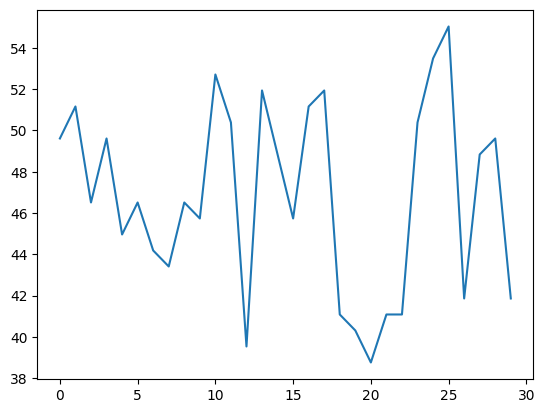

In [195]:
plt.plot(sample_percentage)

In [196]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


def repeat(test_split, test_result, start, end):
    mx = 0
    size = 0
    data = []
    f1=[]
    for i in range(start,end):
        data = some_pred(test_split, i)
        tn, fp, fn, tp = confusion_matrix(test_result, data).ravel()
        precision = tp / (tp+ fp)
        recall = tp / (tp+ fn)
        score = (2 * precision * recall) / (precision + recall)
        print(score)
        f1.append(score)
        if mx < score:
            mx = score
            size = i
        print(i)
    print(mx,size)
    return data, f1

# a = ensemble[0].predict(test_split)

def some_pred(test_split, esize):
#     data = []
    k = []
#     for j in range(len(test_split)):
#         pa=0
#         na =0
    for i in range(esize):
        print('*********:', i)
        k.append(ensemble[i].predict([test_split]))
        # if pa >=na:
        #     data.append(1)
        # else:
        #     data.append(0)
    # f1.append(f1_score(test_result, data, average="macro"))
    # acc.append(accuracy_score(test_result, data))
    return k

In [197]:

def majority(data):
    ans =[]
    for i in range(len(data[0])):
        ap = 0
        an = 0
        for e in range(len(data)):
            if data[e][i] >= .5:
                ap += alphas[e]
            else:
                an += alphas[e]
        if ap >= an:
            ans.append(1)
        else:
            ans.append(0)
    return ans


In [198]:
def getf1(true, predicted):
    tn, fp, fn, tp = confusion_matrix(true, predicted).ravel()
    precision = tp / (tp+ fp)
    recall = tp / (tp+ fn)
    score = ( precision , recall, (2*precision*recall)/(precision+recall))
    return score

In [199]:
f1_test = []
acc_test = []
for i in range(1,ensemble_size+1):
    data = some_pred(test_split, i)
    ans = majority(data)
    f1_test.append(getf1(test_result, ans))
    acc_test.append(accuracy_score(test_result, ans))

2022-11-15 08:42:20.931566: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


*********: 0
3/3 [==============================] - 0s 39ms/step
*********: 0
3/3 [==============================] - 0s 3ms/step
*********: 1
3/3 [==============================] - 0s 27ms/step
*********: 0
3/3 [==============================] - 0s 14ms/step


2022-11-15 08:42:21.171695: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


*********: 1
3/3 [==============================] - 0s 3ms/step
*********: 2
3/3 [==============================] - 0s 29ms/step
*********: 0
3/3 [==============================] - 0s 3ms/step


2022-11-15 08:42:21.483332: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


*********: 1
3/3 [==============================] - 0s 13ms/step
*********: 2
3/3 [==============================] - 0s 8ms/step
*********: 3
3/3 [==============================] - 0s 22ms/step
*********: 0
3/3 [==============================] - 0s 10ms/step
*********: 1
1/3 [=========>....................] - ETA: 0s

2022-11-15 08:42:21.810670: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 3ms/step
*********: 2
3/3 [==============================] - 0s 9ms/step
*********: 3
3/3 [==============================] - 0s 9ms/step
*********: 4
3/3 [==============================] - 0s 36ms/step
*********: 0
3/3 [==============================] - 0s 3ms/step


2022-11-15 08:42:22.163254: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


*********: 1
3/3 [==============================] - 0s 3ms/step
*********: 2
3/3 [==============================] - 0s 3ms/step
*********: 3
3/3 [==============================] - 0s 3ms/step
*********: 4
3/3 [==============================] - 0s 13ms/step
*********: 5
3/3 [==============================] - 0s 33ms/step
*********: 0
3/3 [==============================] - 0s 3ms/step
*********: 1
1/3 [=========>....................] - ETA: 0s

2022-11-15 08:42:22.577836: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 3ms/step
*********: 2
3/3 [==============================] - 0s 10ms/step
*********: 3
3/3 [==============================] - 0s 3ms/step
*********: 4
3/3 [==============================] - 0s 3ms/step
*********: 5
3/3 [==============================] - 0s 9ms/step
*********: 6
3/3 [==============================] - 0s 37ms/step
*********: 0
3/3 [==============================] - 0s 2ms/step


2022-11-15 08:42:23.035045: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


*********: 1
3/3 [==============================] - 0s 3ms/step
*********: 2
3/3 [==============================] - 0s 3ms/step
*********: 3
3/3 [==============================] - 0s 3ms/step
*********: 4
3/3 [==============================] - 0s 9ms/step
*********: 5
3/3 [==============================] - 0s 2ms/step
*********: 6
3/3 [==============================] - 0s 2ms/step
*********: 7
3/3 [==============================] - 0s 32ms/step
*********: 0
3/3 [==============================] - 0s 3ms/step
*********: 1


2022-11-15 08:42:23.503018: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 12ms/step
*********: 2
3/3 [==============================] - 0s 3ms/step
*********: 3
3/3 [==============================] - 0s 12ms/step
*********: 4
3/3 [==============================] - 0s 11ms/step
*********: 5
3/3 [==============================] - 0s 10ms/step
*********: 6
3/3 [==============================] - 0s 11ms/step
*********: 7
3/3 [==============================] - 0s 9ms/step
*********: 8
3/3 [==============================] - 0s 34ms/step
*********: 0
3/3 [==============================] - 0s 3ms/step
*********: 1
1/3 [=========>....................] - ETA: 0s

2022-11-15 08:42:24.125636: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 3ms/step
*********: 2
3/3 [==============================] - 0s 4ms/step
*********: 3
3/3 [==============================] - 0s 16ms/step
*********: 4
3/3 [==============================] - 0s 2ms/step
*********: 5
3/3 [==============================] - 0s 3ms/step
*********: 6
3/3 [==============================] - 0s 10ms/step
*********: 7
3/3 [==============================] - 0s 9ms/step
*********: 8
3/3 [==============================] - 0s 10ms/step
*********: 9
3/3 [==============================] - 0s 26ms/step
*********: 0
3/3 [==============================] - 0s 3ms/step
*********: 1
3/3 [==============================] - 0s 3ms/step


2022-11-15 08:42:24.736712: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


*********: 2
3/3 [==============================] - 0s 10ms/step
*********: 3
3/3 [==============================] - 0s 2ms/step
*********: 4
3/3 [==============================] - 0s 4ms/step
*********: 5
3/3 [==============================] - 0s 2ms/step
*********: 6
3/3 [==============================] - 0s 4ms/step
*********: 7
3/3 [==============================] - 0s 3ms/step
*********: 8
3/3 [==============================] - 0s 9ms/step
*********: 9
3/3 [==============================] - 0s 9ms/step
*********: 10
3/3 [==============================] - 0s 29ms/step
*********: 0
3/3 [==============================] - 0s 3ms/step


2022-11-15 08:42:25.323755: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


*********: 1
3/3 [==============================] - 0s 3ms/step
*********: 2
3/3 [==============================] - 0s 3ms/step
*********: 3
3/3 [==============================] - 0s 3ms/step
*********: 4
3/3 [==============================] - 0s 3ms/step
*********: 5
3/3 [==============================] - 0s 9ms/step
*********: 6
3/3 [==============================] - 0s 8ms/step
*********: 7
3/3 [==============================] - 0s 3ms/step
*********: 8
3/3 [==============================] - 0s 3ms/step
*********: 9
3/3 [==============================] - 0s 15ms/step
*********: 10
3/3 [==============================] - 0s 3ms/step
*********: 11
3/3 [==============================] - 0s 22ms/step
*********: 0
3/3 [==============================] - 0s 3ms/step
*********: 1
3/3 [==============================] - 0s 8ms/step


2022-11-15 08:42:25.939532: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


*********: 2
3/3 [==============================] - 0s 3ms/step
*********: 3
3/3 [==============================] - 0s 3ms/step
*********: 4
3/3 [==============================] - 0s 8ms/step
*********: 5
3/3 [==============================] - 0s 3ms/step
*********: 6
3/3 [==============================] - 0s 4ms/step
*********: 7
3/3 [==============================] - 0s 10ms/step
*********: 8
3/3 [==============================] - 0s 2ms/step
*********: 9
3/3 [==============================] - 0s 3ms/step
*********: 10
3/3 [==============================] - 0s 16ms/step
*********: 11
3/3 [==============================] - 0s 9ms/step
*********: 12
3/3 [==============================] - 0s 35ms/step
*********: 0
3/3 [==============================] - 0s 3ms/step
*********: 1
3/3 [==============================] - 0s 3ms/step


2022-11-15 08:42:26.610270: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


*********: 2
3/3 [==============================] - 0s 4ms/step
*********: 3
3/3 [==============================] - 0s 3ms/step
*********: 4
3/3 [==============================] - 0s 3ms/step
*********: 5
3/3 [==============================] - 0s 3ms/step
*********: 6
3/3 [==============================] - 0s 4ms/step
*********: 7
3/3 [==============================] - 0s 10ms/step
*********: 8
3/3 [==============================] - 0s 3ms/step
*********: 9
3/3 [==============================] - 0s 3ms/step
*********: 10
3/3 [==============================] - 0s 16ms/step
*********: 11
3/3 [==============================] - 0s 9ms/step
*********: 12
3/3 [==============================] - 0s 9ms/step
*********: 13
3/3 [==============================] - 0s 37ms/step
*********: 0
3/3 [==============================] - 0s 3ms/step
*********: 1
1/3 [=========>....................] - ETA: 0s

2022-11-15 08:42:27.353082: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 4ms/step
*********: 2
3/3 [==============================] - 0s 3ms/step
*********: 3
3/3 [==============================] - 0s 3ms/step
*********: 4
3/3 [==============================] - 0s 3ms/step
*********: 5
3/3 [==============================] - 0s 3ms/step
*********: 6
3/3 [==============================] - 0s 3ms/step
*********: 7
3/3 [==============================] - 0s 3ms/step
*********: 8
3/3 [==============================] - 0s 8ms/step
*********: 9
3/3 [==============================] - 0s 3ms/step
*********: 10
3/3 [==============================] - 0s 3ms/step
*********: 11
3/3 [==============================] - 0s 3ms/step
*********: 12
3/3 [==============================] - 0s 16ms/step
*********: 13
3/3 [==============================] - 0s 9ms/step
*********: 14
3/3 [==============================] - 0s 33ms/step
*********: 0
3/3 [==============================] - 0s 3ms/step
*********: 1
1/3 [=========>..................

2022-11-15 08:42:28.102381: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 3ms/step
*********: 2
3/3 [==============================] - 0s 3ms/step
*********: 3
3/3 [==============================] - 0s 3ms/step
*********: 4
3/3 [==============================] - 0s 3ms/step
*********: 5
3/3 [==============================] - 0s 3ms/step
*********: 6
3/3 [==============================] - 0s 3ms/step
*********: 7
3/3 [==============================] - 0s 3ms/step
*********: 8
3/3 [==============================] - 0s 3ms/step
*********: 9
3/3 [==============================] - 0s 9ms/step
*********: 10
3/3 [==============================] - 0s 2ms/step
*********: 11
3/3 [==============================] - 0s 9ms/step
*********: 12
3/3 [==============================] - 0s 9ms/step
*********: 13
3/3 [==============================] - 0s 9ms/step
*********: 14
3/3 [==============================] - 0s 3ms/step
*********: 15
3/3 [==============================] - 0s 30ms/step
*********: 0
3/3 [============================

2022-11-15 08:42:28.895236: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 3ms/step
*********: 2
3/3 [==============================] - 0s 3ms/step
*********: 3
3/3 [==============================] - 0s 4ms/step
*********: 4
3/3 [==============================] - 0s 4ms/step
*********: 5
3/3 [==============================] - 0s 3ms/step
*********: 6
3/3 [==============================] - 0s 3ms/step
*********: 7
3/3 [==============================] - 0s 3ms/step
*********: 8
3/3 [==============================] - 0s 3ms/step
*********: 9
3/3 [==============================] - 0s 3ms/step
*********: 10
3/3 [==============================] - 0s 9ms/step
*********: 11
3/3 [==============================] - 0s 2ms/step
*********: 12
3/3 [==============================] - 0s 3ms/step
*********: 13
3/3 [==============================] - 0s 8ms/step
*********: 14
3/3 [==============================] - 0s 9ms/step
*********: 15
3/3 [==============================] - 0s 8ms/step
*********: 16
3/3 [============================

2022-11-15 08:42:29.709797: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


*********: 3
3/3 [==============================] - 0s 4ms/step
*********: 4
3/3 [==============================] - 0s 2ms/step
*********: 5
3/3 [==============================] - 0s 3ms/step
*********: 6
3/3 [==============================] - 0s 3ms/step
*********: 7
3/3 [==============================] - 0s 3ms/step
*********: 8
3/3 [==============================] - 0s 4ms/step
*********: 9
3/3 [==============================] - 0s 3ms/step
*********: 10
3/3 [==============================] - 0s 3ms/step
*********: 11
3/3 [==============================] - 0s 3ms/step
*********: 12
3/3 [==============================] - 0s 2ms/step
*********: 13
3/3 [==============================] - 0s 3ms/step
*********: 14
3/3 [==============================] - 0s 4ms/step
*********: 15
3/3 [==============================] - 0s 3ms/step
*********: 16
3/3 [==============================] - 0s 3ms/step
*********: 17
3/3 [==============================] - 0s 25ms/step
*********: 0
3/3 [=============

2022-11-15 08:42:30.486625: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


*********: 2
3/3 [==============================] - 0s 3ms/step
*********: 3
3/3 [==============================] - 0s 4ms/step
*********: 4
3/3 [==============================] - 0s 4ms/step
*********: 5
3/3 [==============================] - 0s 3ms/step
*********: 6
3/3 [==============================] - 0s 3ms/step
*********: 7
3/3 [==============================] - 0s 3ms/step
*********: 8
3/3 [==============================] - 0s 3ms/step
*********: 9
3/3 [==============================] - 0s 3ms/step
*********: 10
3/3 [==============================] - 0s 3ms/step
*********: 11
3/3 [==============================] - 0s 3ms/step
*********: 12
3/3 [==============================] - 0s 3ms/step
*********: 13
3/3 [==============================] - 0s 2ms/step
*********: 14
3/3 [==============================] - 0s 9ms/step
*********: 15
3/3 [==============================] - 0s 8ms/step
*********: 16
3/3 [==============================] - 0s 10ms/step
*********: 17
3/3 [=============

2022-11-15 08:42:31.381305: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


*********: 2
3/3 [==============================] - 0s 3ms/step
*********: 3
3/3 [==============================] - 0s 3ms/step
*********: 4
3/3 [==============================] - 0s 3ms/step
*********: 5
3/3 [==============================] - 0s 3ms/step
*********: 6
3/3 [==============================] - 0s 3ms/step
*********: 7
3/3 [==============================] - 0s 4ms/step
*********: 8
3/3 [==============================] - 0s 3ms/step
*********: 9
3/3 [==============================] - 0s 3ms/step
*********: 10
3/3 [==============================] - 0s 2ms/step
*********: 11
3/3 [==============================] - 0s 3ms/step
*********: 12
3/3 [==============================] - 0s 2ms/step
*********: 13
3/3 [==============================] - 0s 3ms/step
*********: 14
3/3 [==============================] - 0s 9ms/step
*********: 15
3/3 [==============================] - 0s 3ms/step
*********: 16
3/3 [==============================] - 0s 10ms/step
*********: 17
3/3 [=============

2022-11-15 08:42:32.323945: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 2ms/step
*********: 2
3/3 [==============================] - 0s 3ms/step
*********: 3
3/3 [==============================] - 0s 3ms/step
*********: 4
3/3 [==============================] - 0s 3ms/step
*********: 5
3/3 [==============================] - 0s 3ms/step
*********: 6
3/3 [==============================] - 0s 3ms/step
*********: 7
3/3 [==============================] - 0s 3ms/step
*********: 8
3/3 [==============================] - 0s 3ms/step
*********: 9
3/3 [==============================] - 0s 3ms/step
*********: 10
3/3 [==============================] - 0s 3ms/step
*********: 11
3/3 [==============================] - 0s 3ms/step
*********: 12
3/3 [==============================] - 0s 3ms/step
*********: 13
3/3 [==============================] - 0s 2ms/step
*********: 14
3/3 [==============================] - 0s 2ms/step
*********: 15
3/3 [==============================] - 0s 3ms/step
*********: 16
3/3 [============================

2022-11-15 08:42:33.292281: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 3ms/step
*********: 2
3/3 [==============================] - 0s 3ms/step
*********: 3
3/3 [==============================] - 0s 5ms/step
*********: 4
3/3 [==============================] - 0s 3ms/step
*********: 5
3/3 [==============================] - 0s 3ms/step
*********: 6
3/3 [==============================] - 0s 3ms/step
*********: 7
3/3 [==============================] - 0s 3ms/step
*********: 8
3/3 [==============================] - 0s 3ms/step
*********: 9
3/3 [==============================] - 0s 3ms/step
*********: 10
3/3 [==============================] - 0s 3ms/step
*********: 11
3/3 [==============================] - 0s 3ms/step
*********: 12
3/3 [==============================] - 0s 3ms/step
*********: 13
3/3 [==============================] - 0s 3ms/step
*********: 14
3/3 [==============================] - 0s 3ms/step
*********: 15
3/3 [==============================] - 0s 9ms/step
*********: 16
3/3 [============================

2022-11-15 08:42:34.271736: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


*********: 2
3/3 [==============================] - 0s 3ms/step
*********: 3
3/3 [==============================] - 0s 2ms/step
*********: 4
3/3 [==============================] - 0s 4ms/step
*********: 5
3/3 [==============================] - 0s 4ms/step
*********: 6
3/3 [==============================] - 0s 3ms/step
*********: 7
3/3 [==============================] - 0s 3ms/step
*********: 8
3/3 [==============================] - 0s 2ms/step
*********: 9
3/3 [==============================] - 0s 3ms/step
*********: 10
3/3 [==============================] - 0s 3ms/step
*********: 11
3/3 [==============================] - 0s 3ms/step
*********: 12
3/3 [==============================] - 0s 3ms/step
*********: 13
3/3 [==============================] - 0s 3ms/step
*********: 14
3/3 [==============================] - 0s 3ms/step
*********: 15
3/3 [==============================] - 0s 8ms/step
*********: 16
3/3 [==============================] - 0s 9ms/step
*********: 17
3/3 [==============

2022-11-15 08:42:35.274269: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


*********: 2
3/3 [==============================] - 0s 3ms/step
*********: 3
3/3 [==============================] - 0s 3ms/step
*********: 4
3/3 [==============================] - 0s 3ms/step
*********: 5
3/3 [==============================] - 0s 3ms/step
*********: 6
3/3 [==============================] - 0s 3ms/step
*********: 7
3/3 [==============================] - 0s 3ms/step
*********: 8
3/3 [==============================] - 0s 3ms/step
*********: 9
3/3 [==============================] - 0s 3ms/step
*********: 10
3/3 [==============================] - 0s 2ms/step
*********: 11
3/3 [==============================] - 0s 2ms/step
*********: 12
3/3 [==============================] - 0s 2ms/step
*********: 13
3/3 [==============================] - 0s 3ms/step
*********: 14
3/3 [==============================] - 0s 2ms/step
*********: 15
3/3 [==============================] - 0s 3ms/step
*********: 16
3/3 [==============================] - 0s 2ms/step
*********: 17
3/3 [==============

2022-11-15 08:42:36.348964: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


*********: 2
3/3 [==============================] - 0s 3ms/step
*********: 3
3/3 [==============================] - 0s 3ms/step
*********: 4
3/3 [==============================] - 0s 3ms/step
*********: 5
3/3 [==============================] - 0s 3ms/step
*********: 6
3/3 [==============================] - 0s 3ms/step
*********: 7
3/3 [==============================] - 0s 3ms/step
*********: 8
3/3 [==============================] - 0s 9ms/step
*********: 9
3/3 [==============================] - 0s 3ms/step
*********: 10
3/3 [==============================] - 0s 3ms/step
*********: 11
3/3 [==============================] - 0s 3ms/step
*********: 12
3/3 [==============================] - 0s 2ms/step
*********: 13
3/3 [==============================] - 0s 2ms/step
*********: 14
3/3 [==============================] - 0s 2ms/step
*********: 15
3/3 [==============================] - 0s 2ms/step
*********: 16
3/3 [==============================] - 0s 3ms/step
*********: 17
3/3 [==============

2022-11-15 08:42:37.396674: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


*********: 2
3/3 [==============================] - 0s 4ms/step
*********: 3
3/3 [==============================] - 0s 3ms/step
*********: 4
3/3 [==============================] - 0s 3ms/step
*********: 5
3/3 [==============================] - 0s 3ms/step
*********: 6
3/3 [==============================] - 0s 3ms/step
*********: 7
3/3 [==============================] - 0s 3ms/step
*********: 8
3/3 [==============================] - 0s 3ms/step
*********: 9
3/3 [==============================] - 0s 3ms/step
*********: 10
3/3 [==============================] - 0s 3ms/step
*********: 11
3/3 [==============================] - 0s 3ms/step
*********: 12
3/3 [==============================] - 0s 3ms/step
*********: 13
3/3 [==============================] - 0s 3ms/step
*********: 14
3/3 [==============================] - 0s 3ms/step
*********: 15
3/3 [==============================] - 0s 2ms/step
*********: 16
3/3 [==============================] - 0s 2ms/step
*********: 17
3/3 [==============

2022-11-15 08:42:38.511337: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


*********: 2
3/3 [==============================] - 0s 3ms/step
*********: 3
3/3 [==============================] - 0s 3ms/step
*********: 4
3/3 [==============================] - 0s 3ms/step
*********: 5
3/3 [==============================] - 0s 3ms/step
*********: 6
3/3 [==============================] - 0s 3ms/step
*********: 7
3/3 [==============================] - 0s 4ms/step
*********: 8
3/3 [==============================] - 0s 3ms/step
*********: 9
3/3 [==============================] - 0s 3ms/step
*********: 10
3/3 [==============================] - 0s 3ms/step
*********: 11
3/3 [==============================] - 0s 3ms/step
*********: 12
3/3 [==============================] - 0s 3ms/step
*********: 13
3/3 [==============================] - 0s 9ms/step
*********: 14
3/3 [==============================] - 0s 3ms/step
*********: 15
3/3 [==============================] - 0s 3ms/step
*********: 16
3/3 [==============================] - 0s 3ms/step
*********: 17
3/3 [==============

2022-11-15 08:42:39.743663: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 3ms/step
*********: 2
3/3 [==============================] - 0s 3ms/step
*********: 3
3/3 [==============================] - 0s 2ms/step
*********: 4
3/3 [==============================] - 0s 3ms/step
*********: 5
3/3 [==============================] - 0s 3ms/step
*********: 6
3/3 [==============================] - 0s 3ms/step
*********: 7
3/3 [==============================] - 0s 3ms/step
*********: 8
3/3 [==============================] - 0s 3ms/step
*********: 9
3/3 [==============================] - 0s 3ms/step
*********: 10
3/3 [==============================] - 0s 3ms/step
*********: 11
3/3 [==============================] - 0s 3ms/step
*********: 12
3/3 [==============================] - 0s 3ms/step
*********: 13
3/3 [==============================] - 0s 3ms/step
*********: 14
3/3 [==============================] - 0s 3ms/step
*********: 15
3/3 [==============================] - 0s 2ms/step
*********: 16
3/3 [============================

2022-11-15 08:42:40.968102: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


*********: 2
3/3 [==============================] - 0s 3ms/step
*********: 3
3/3 [==============================] - 0s 3ms/step
*********: 4
3/3 [==============================] - 0s 3ms/step
*********: 5
3/3 [==============================] - 0s 3ms/step
*********: 6
3/3 [==============================] - 0s 2ms/step
*********: 7
3/3 [==============================] - 0s 3ms/step
*********: 8
3/3 [==============================] - 0s 3ms/step
*********: 9
3/3 [==============================] - 0s 3ms/step
*********: 10
3/3 [==============================] - 0s 3ms/step
*********: 11
3/3 [==============================] - 0s 3ms/step
*********: 12
3/3 [==============================] - 0s 3ms/step
*********: 13
3/3 [==============================] - 0s 3ms/step
*********: 14
3/3 [==============================] - 0s 3ms/step
*********: 15
3/3 [==============================] - 0s 2ms/step
*********: 16
3/3 [==============================] - 0s 3ms/step
*********: 17
3/3 [==============

2022-11-15 08:42:42.147749: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 3ms/step
*********: 3
3/3 [==============================] - 0s 4ms/step
*********: 4
3/3 [==============================] - 0s 3ms/step
*********: 5
3/3 [==============================] - 0s 4ms/step
*********: 6
3/3 [==============================] - 0s 3ms/step
*********: 7
3/3 [==============================] - 0s 4ms/step
*********: 8
3/3 [==============================] - 0s 3ms/step
*********: 9
3/3 [==============================] - 0s 3ms/step
*********: 10
3/3 [==============================] - 0s 3ms/step
*********: 11
3/3 [==============================] - 0s 3ms/step
*********: 12
3/3 [==============================] - 0s 3ms/step
*********: 13
3/3 [==============================] - 0s 2ms/step
*********: 14
3/3 [==============================] - 0s 2ms/step
*********: 15
3/3 [==============================] - 0s 2ms/step
*********: 16
3/3 [==============================] - 0s 2ms/step
*********: 17
3/3 [===========================

2022-11-15 08:42:43.417441: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [200]:
f1_train = []
acc_train = []
for i in range(1,ensemble_size+1):
    data = some_pred(training_split, i)
    ans = majority(data)
    f1_train.append(getf1(train_result, ans))
    acc_train.append(accuracy_score(train_result, ans))
    # ConfusionMatrixDisplay.from_predictions(test_result,ans,cmap='Greens')

*********: 0
41/41 [==============================] - 0s 4ms/step
*********: 0
41/41 [==============================] - 0s 3ms/step
*********: 1
41/41 [==============================] - 0s 3ms/step
*********: 0
41/41 [==============================] - 0s 2ms/step
*********: 1
41/41 [==============================] - 0s 3ms/step
*********: 2
41/41 [==============================] - 0s 4ms/step
*********: 0
41/41 [==============================] - 0s 3ms/step
*********: 1
41/41 [==============================] - 0s 2ms/step
*********: 2
41/41 [==============================] - 0s 2ms/step
*********: 3
41/41 [==============================] - 0s 3ms/step
*********: 0
41/41 [==============================] - 0s 3ms/step
*********: 1
41/41 [==============================] - 0s 3ms/step
*********: 2
41/41 [==============================] - 0s 2ms/step
*********: 3
41/41 [==============================] - 0s 3ms/step
*********: 4
41/41 [==============================] - 0s 3ms/step
*********:

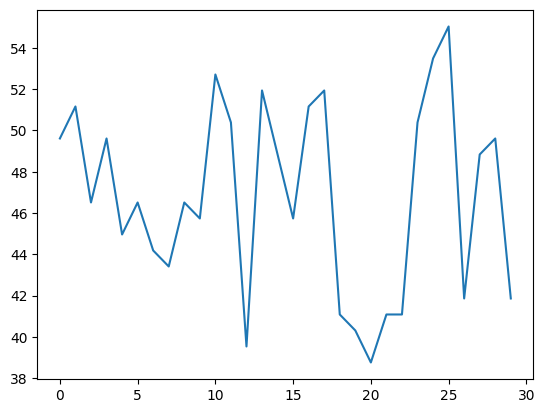

In [201]:
plt.plot(sample_percentage)

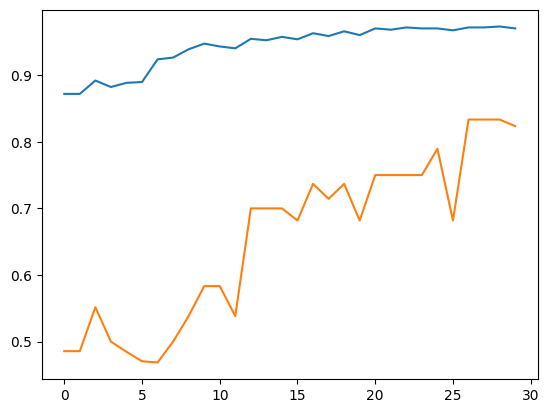

In [202]:
plt.plot([i[0] for i in f1_train])
plt.plot([i[0] for i in f1_test])
# plt.plot()

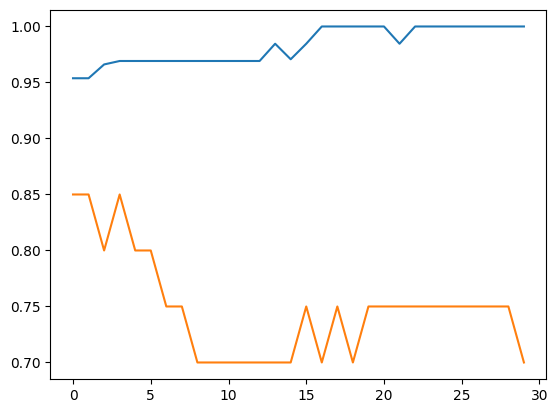

In [203]:
plt.plot([i[1] for i in f1_train])
plt.plot([i[1] for i in f1_test])

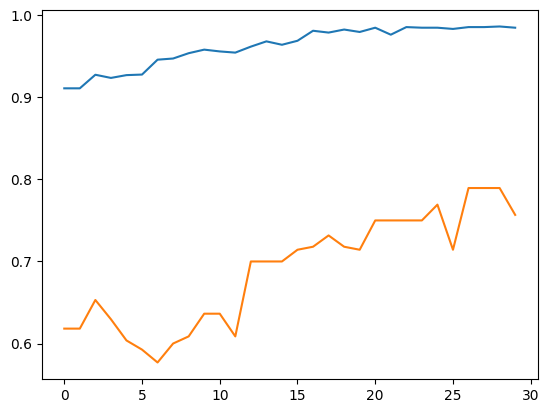

In [205]:
plt.plot([i[2] for i in f1_train])
plt.plot([i[2] for i in f1_test])

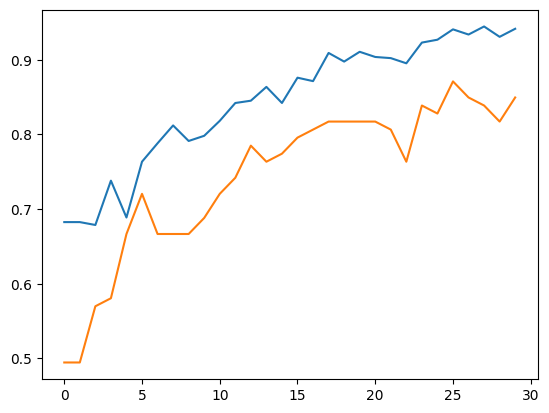

In [186]:
plt.plot(acc_train)
plt.plot(acc_test)

In [218]:
f1_test[17]

(0.7142857142857143, 0.75, 0.7317073170731706)

In [219]:
value = 17
data = some_pred(training_split, value+1)
ans = majority(data)
data = some_pred(test_split, value +1)
ans1 = majority(data)


*********: 0
41/41 [==============================] - 0s 3ms/step
*********: 1
41/41 [==============================] - 0s 3ms/step
*********: 2
41/41 [==============================] - 0s 3ms/step
*********: 3
41/41 [==============================] - 0s 3ms/step
*********: 4
41/41 [==============================] - 0s 3ms/step
*********: 5
41/41 [==============================] - 0s 3ms/step
*********: 6
41/41 [==============================] - 0s 3ms/step
*********: 7
41/41 [==============================] - 0s 3ms/step
*********: 8
41/41 [==============================] - 0s 3ms/step
*********: 9
41/41 [==============================] - 0s 3ms/step
*********: 10
41/41 [==============================] - 0s 3ms/step
*********: 11
41/41 [==============================] - 0s 3ms/step
*********: 12
41/41 [==============================] - 0s 3ms/step
*********: 13
41/41 [==============================] - 0s 3ms/step
*********: 14
41/41 [==============================] - 0s 3ms/step
*****

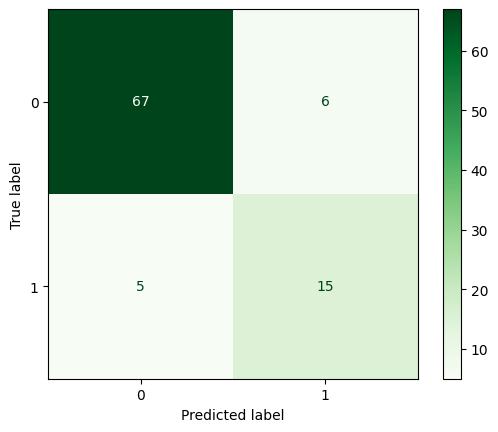

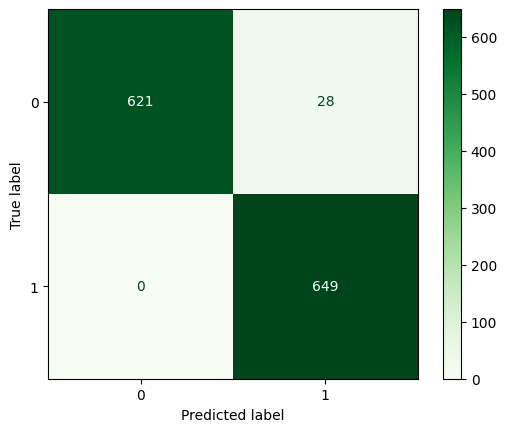

In [220]:
ConfusionMatrixDisplay.from_predictions(test_result,ans1,cmap='Greens')
# plt.plot(f1_test)
ConfusionMatrixDisplay.from_predictions(train_result,ans,cmap='Greens')

In [221]:
value = 28
data = some_pred(training_split, value+1)
ans = majority(data)
data = some_pred(test_split, value+1 )
ans1 = majority(data)

*********: 0
41/41 [==============================] - 0s 3ms/step
*********: 1
41/41 [==============================] - 0s 3ms/step
*********: 2
41/41 [==============================] - 0s 3ms/step
*********: 3
41/41 [==============================] - 0s 3ms/step
*********: 4
41/41 [==============================] - 0s 3ms/step
*********: 5
41/41 [==============================] - 0s 3ms/step
*********: 6
41/41 [==============================] - 0s 2ms/step
*********: 7
41/41 [==============================] - 0s 3ms/step
*********: 8
41/41 [==============================] - 0s 2ms/step
*********: 9
41/41 [==============================] - 0s 3ms/step
*********: 10
41/41 [==============================] - 0s 3ms/step
*********: 11
41/41 [==============================] - 0s 3ms/step
*********: 12
41/41 [==============================] - 0s 3ms/step
*********: 13
41/41 [==============================] - 0s 3ms/step
*********: 14
41/41 [==============================] - 0s 3ms/step
*****

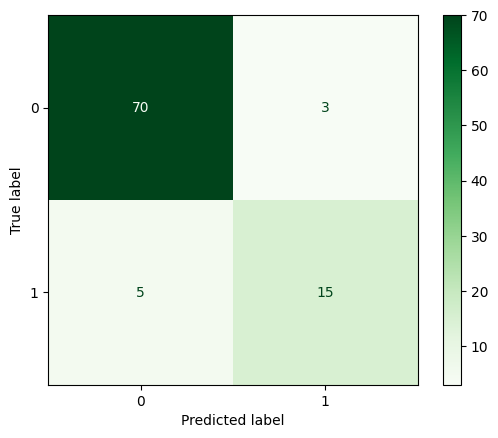

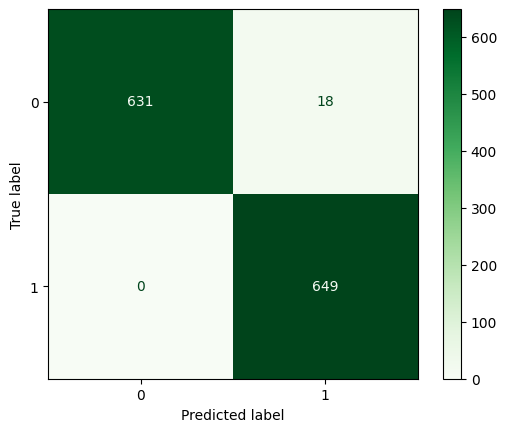

In [222]:
ConfusionMatrixDisplay.from_predictions(test_result,ans1,cmap='Greens')
# plt.plot(f1_test)
ConfusionMatrixDisplay.from_predictions(train_result,ans,cmap='Greens')

In [215]:
table_test = pd.read_table('./1663769555_8653905_test.txt', names=['sequence'])
unlabeled_test = vectorizer_best.transform(table_test.sequence).toarray()
predicted_data = majority(some_pred(unlabeled_test, 28+1))

*********: 0
11/11 [==============================] - 0s 9ms/step
*********: 1
11/11 [==============================] - 0s 13ms/step
*********: 2
11/11 [==============================] - 0s 7ms/step
*********: 3
11/11 [==============================] - 0s 7ms/step
*********: 4
11/11 [==============================] - 0s 12ms/step
*********: 5
11/11 [==============================] - 0s 7ms/step
*********: 6
11/11 [==============================] - 0s 9ms/step
*********: 7
11/11 [==============================] - 0s 7ms/step
*********: 8
11/11 [==============================] - 0s 8ms/step
*********: 9
11/11 [==============================] - 0s 8ms/step
*********: 10
11/11 [==============================] - 0s 8ms/step
*********: 11
11/11 [==============================] - 0s 7ms/step
*********: 12
11/11 [==============================] - 0s 6ms/step
*********: 13
11/11 [==============================] - 0s 9ms/step
*********: 14
11/11 [==============================] - 0s 6ms/step
***

In [216]:
len(predicted_data)

350

In [217]:
import csv
outfile = open('./results.csv','w')
out = csv.writer(outfile)
out.writerows(map(lambda x: [x], predicted_data))
outfile.close()